# Modelo Predictivo de Precios de Casas

## Dependencias

In [1]:
import pandas as pd
import numpy as np
from numpy import arange 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as tt_split 
from sklearn.preprocessing import StandardScaler as SScaler

import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LinearRegression as Lreg
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.metrics import accuracy_score as acc
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error as MSLE #se usa este indicador porque es lo que se pide optimizar

## Carga de Datos

In [109]:
#Set de entrenamiento
df = pd.read_csv('train.csv')

In [6]:
##df.info()

In [3]:
train_info = df.describe().iloc[1,:]

In [104]:
df_test = pd.read_csv('test.csv')

In [5]:
test_info = df_test.describe().iloc[1,:]

In [ ]:
#Diferencia entre set de entrenamiento y prueba
#Esta parte es necesaria dada la competencia, no seria un tema si fuera un caso real producto 
#de que nos encargariamos de que la distribucion tuviera las mismas caracteristicas en 
#entrenamiento y prueba

In [74]:
#Diferencia Absoluta
#Esto se hace para comprobar que la distribucion de entrenamiento sea igual a la de prueba
abs((train_info - test_info)/test_info).sort_values(ascending=False)

3SsnPorch        0.900149
Id               0.666438
LowQualFinSF     0.649353
PoolArea         0.581627
MiscVal          0.252354
BsmtHalfBath     0.117606
ScreenPorch      0.117406
BsmtFinSF2       0.115357
EnclosedPorch    0.094426
LotArea          0.071052
2ndFlrSF         0.064499
Fireplaces       0.054702
MoSold           0.035670
OpenPorchSF      0.034227
MasVnrArea       0.029552
BsmtUnfSF        0.023355
LotFrontage      0.021429
BsmtFullBath     0.020973
TotRmsAbvGrd     0.020769
GrLivArea        0.019796
HalfBath         0.013824
WoodDeckSF       0.011481
TotalBsmtSF      0.010813
BsmtFinSF1       0.010100
MSSubClass       0.008384
1stFlrSF         0.005268
BedroomAbvGr     0.004355
KitchenAbvGr     0.003914
OverallCond      0.003878
FullBath         0.003737
OverallQual      0.003371
YearRemodAdd     0.000606
GarageCars       0.000569
GarageArea       0.000447
GarageYrBlt      0.000397
YearBuilt        0.000046
YrSold           0.000023
SalePrice             NaN
Name: mean, 

In [11]:
#Explorando las variables

In [6]:
from pandas_profiling import ProfileReport as PR

In [7]:
prof = PR(df)
prof.to_file(output_file='train_ds.html')

prof2 = PR(df_test)
prof.to_file(output_file='test_ds.html')

KeyboardInterrupt: 

# Funciones de Generación de Variables

In [3]:
#Variables Continuas
def get_var_con(df):
    df_con = df[['OverallQual','OverallCond','YearBuilt',\
             'TotalBsmtSF','GarageYrBlt','Fireplaces',\
             'GarageArea','FullBath','HalfBath',\
             '2ndFlrSF','GrLivArea','YearRemodAdd',\
             'MasVnrArea'
             ]]
    return df_con

In [4]:
#Diccionario de cambios
Variables_dict = [ \
[['Utilities'],{'AllPub':4,'NoSewr':3, 'NoSeWa':2, 'ELO':1}], \
[['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC',\
  'KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC'] \
 , {'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.nan : 0}], \
[['BsmtExposure'] , {'Gd':4,'Av':3, 'Mn':2, 'No':1, np.nan : 0}], \
[['BsmtFinType1','BsmtFinType2'] , {'GLQ':6,'ALQ':5, 'BLQ':4, 'Rec':3,'LwQ':2,'Unf':1,np.nan : 0}], \
[['CentralAir'],{'N':0, 'Y':1 ,np.nan : 0}], \
[['GarageFinish'] , {'Fin':3,'RFn':2, 'Unf':1, np.nan : 0}], \
[['Fence'] , {'GdPrv':4,'MnPrv':3, 'GdWo':2, 'MnWw':1, np.nan : 0}] \
]

In [5]:
def reemplazo_dict(df, x, dic):
    df[x] = df[x].map(dic).fillna(df[x])
    return df

In [6]:
def get_var_dicc(df):
    #Variables para Cambio por diccionario
    df_dict = df[['Utilities',
    'ExterQual','ExterCond','BsmtQual','BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'CentralAir',
    'KitchenQual',
    'FireplaceQu',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence']]
    for elemento in Variables_dict:
        for columna in elemento[0]:
            df_dict = reemplazo_dict(df_dict, columna, elemento[1])  
    return df_dict

In [7]:
def AgregaOneHotEncoding(df, x):
    lista_tipos = tuple(df[x].unique())
    sub_df = pd.DataFrame(lista_tipos, columns=[x])
    dum_df = pd.get_dummies(sub_df, columns = [x], prefix = [x] )
    sub_df = sub_df.join(dum_df)
    sub_df
    
    df_final = df.merge(sub_df, how='left', on=x)
    df_final = df_final.drop(x,1)
    return df_final

In [8]:
def get_var_OHE(df):
    #Variables para OneHotEncoding
    df_OHE = df[['MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'Electrical',
    'Functional',
    'GarageType',
    'PavedDrive',
    'MiscFeature',
    'SaleType',
    'SaleCondition']]
    
    for columna in  list(df_OHE.columns):
        df_OHE = AgregaOneHotEncoding(df_OHE, columna)
    return df_OHE

In [9]:
#Funcion que agrupa los tres tipos de variables y define los flujos para el set de entrenamiento y testeo
def Preprocessing(df,train_flg):
    
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
    df['GarageArea'] = df['GarageArea'].fillna(0)
    
        
    Scale = SScaler()

    if train_flg == 1:
        y = df['SalePrice'].values
        
    
        X1 = get_var_con(df)
        
        X2 = get_var_dicc(df)
        
        X3 = get_var_OHE(df)
 
        
        X = pd.concat([X1,X2,X3], axis=1).values

        X_out = pd.concat([X1,X2,X3], axis=1)

        X_train, X_test, y_train, y_test = tt_split(X, y, train_size= 0.67, random_state=42)



        X_train = Scale.fit_transform(X_train)

        X_test = Scale.fit_transform(X_test)

        X_train = np.nan_to_num(X_train, nan = 0)
        X_test = np.nan_to_num(X_test, nan = 0)
        
        return  X_train, X_test, y_train, y_test, X_out
    else:
        
        X1 = get_var_con(df)
        
        X2 = get_var_dicc(df)
        
        X3 = get_var_OHE(df)
 
        
        X = pd.concat([X1,X2,X3], axis=1)
        
        for element in [item for item in list(data_train.columns) if item not in list(X.columns)]:
            X[element] = 0
        
        X = X[list(data_train.columns)].values
        
        X_out = pd.concat([X1,X2,X3], axis=1)
        
        X_val = Scale.fit_transform(X)
        
        Id = df['Id'].values
        
        X_val = np.nan_to_num(X_val, nan = 0)
        
        return Id , X_val , X_out

In [10]:
#Funcion que prueba Modelos

In [11]:
def Prueba_modelo(X_train, X_test, y_train, y_test , modelo_input, nombre_modelo):
    modelo = modelo_input 
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_pred_train = modelo.predict(X_train)
    
    np.clip(a= y_pred, a_min=0, a_max=None , out=y_pred)
    np.clip(a= y_pred_train, a_min=0, a_max=None , out=y_pred_train)
    
    error = MSLE(y_test, y_pred)
    error_train = MSLE(y_train, y_pred_train)
    dif_error = error - error_train
    
    nombre = nombre_modelo
    modelo_entrenado = modelo
    print(f'Modelo: {nombre}\\ error: {error}\\ error_dif: {dif_error}')
    return [nombre, error ,error_train, dif_error , modelo]

# Modelos de Baseline

In [18]:
#Modelos
Modelos = []

In [41]:
name = 'Linear'
model = Lreg()
Modelos.append([name,model])

TypeError: __init__() got an unexpected keyword argument 'n_estimators'

In [30]:
name = 'Tree'
model = DTR()
Modelos.append([name,model])

In [ ]:
name = 'MultiLayer'
model = MLPC()
Modelos.append([name,model])

In [ ]:
name = f'RandomForest'
model = RFR()
Modelos.append([name,model])

In [ ]:
X_train, X_test, y_train, y_test, data_train = Preprocessing(df,1)

In [ ]:
Output = []

In [ ]:
for modelo in Modelos:
    Output.append(Prueba_modelo(X_train, X_test, y_train, y_test, modelo[1],modelo[0]))

In [ ]:
for modelo in Output:
    final.append(modelo[:-1])   

# Tuning de RandomForest

In [34]:
n_estimators = list(range(10,110,10))
max_depth = list(range(10,110,20))
min_samples_leaf = list(range(1,20,4))
max_features = list(range(20,211,15))

#Iteracion de parametros para encontrar el optimo Random Forest
for n_est in n_estimators:
    for md in max_depth:
        for msl in min_samples_leaf:
            for mf in max_features:
                name = f'RandomForest_{n_est}_{md}_{msl}_{mf}'
                model = RFR(n_estimators=n_est , max_depth = md , min_samples_leaf = msl, max_features= mf)
                Modelos.append([name,model])
                print(f'Modelo: {name}\\')

In [12]:
X_train, X_test, y_train, y_test, data_train = Preprocessing(df,1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
Output = []

In [39]:
for modelo in Modelos:
    Output.append(Prueba_modelo(X_train, X_test, y_train, y_test, modelo[1],modelo[0]))

Modelo: RandomForest_100_20_1_175\ error: 0.022542491490586323\ error_dif: 0.01884055427043
Modelo: RandomForest_10_10_1_20\ error: 0.02884657794227941\ error_dif: 0.01843630019912692
Modelo: RandomForest_10_10_1_35\ error: 0.02614102086001359\ error_dif: 0.018383596652740603
Modelo: RandomForest_10_10_1_50\ error: 0.02422834826688286\ error_dif: 0.018015937175390385
Modelo: RandomForest_10_10_1_65\ error: 0.023987209831399563\ error_dif: 0.01711854221185748
Modelo: RandomForest_10_10_1_80\ error: 0.025115466693161677\ error_dif: 0.01806895907550816
Modelo: RandomForest_10_10_1_95\ error: 0.025586372329637938\ error_dif: 0.019552046321184423
Modelo: RandomForest_10_10_1_110\ error: 0.02436142851071698\ error_dif: 0.018711438505528345
Modelo: RandomForest_10_10_1_125\ error: 0.02442439791795826\ error_dif: 0.01849658012099576
Modelo: RandomForest_10_10_1_140\ error: 0.02496756810385698\ error_dif: 0.018113901107327173
Modelo: RandomForest_10_10_1_155\ error: 0.024041246149403058\ error_

Modelo: RandomForest_10_30_5_170\ error: 0.026624098519918184\ error_dif: 0.0144671580489592
Modelo: RandomForest_10_30_5_185\ error: 0.026522728581592957\ error_dif: 0.01369019048937236
Modelo: RandomForest_10_30_5_200\ error: 0.025250967344131656\ error_dif: 0.012679510744513883
Modelo: RandomForest_10_30_9_20\ error: 0.03435202048825817\ error_dif: 0.010421351774541118
Modelo: RandomForest_10_30_9_35\ error: 0.03174528029144916\ error_dif: 0.009568147813299874
Modelo: RandomForest_10_30_9_50\ error: 0.028695678711805343\ error_dif: 0.009812705366090992
Modelo: RandomForest_10_30_9_65\ error: 0.027284604085700718\ error_dif: 0.00912865951465815
Modelo: RandomForest_10_30_9_80\ error: 0.02898706363539631\ error_dif: 0.010665671113970914
Modelo: RandomForest_10_30_9_95\ error: 0.02821053396574947\ error_dif: 0.009358307867012142
Modelo: RandomForest_10_30_9_110\ error: 0.027648934478463092\ error_dif: 0.00967212906984076
Modelo: RandomForest_10_30_9_125\ error: 0.026610746347072795\ er

Modelo: RandomForest_10_50_13_155\ error: 0.028350158444053357\ error_dif: 0.007942366577528
Modelo: RandomForest_10_50_13_170\ error: 0.02698340426627886\ error_dif: 0.007216296396895843
Modelo: RandomForest_10_50_13_185\ error: 0.029241114873369858\ error_dif: 0.009207898420867274
Modelo: RandomForest_10_50_13_200\ error: 0.027312377538870825\ error_dif: 0.007851769867870551
Modelo: RandomForest_10_50_17_20\ error: 0.038361244688974554\ error_dif: 0.006939074653003537
Modelo: RandomForest_10_50_17_35\ error: 0.0341153922329909\ error_dif: 0.0075886598764266545
Modelo: RandomForest_10_50_17_50\ error: 0.029929413662843393\ error_dif: 0.005806599378993221
Modelo: RandomForest_10_50_17_65\ error: 0.03139031237992168\ error_dif: 0.007451865829362213
Modelo: RandomForest_10_50_17_80\ error: 0.02928306508485294\ error_dif: 0.006310864004839167
Modelo: RandomForest_10_50_17_95\ error: 0.030843136765617375\ error_dif: 0.007302904792962764
Modelo: RandomForest_10_50_17_110\ error: 0.031265724

Modelo: RandomForest_10_90_1_95\ error: 0.02589719848716433\ error_dif: 0.020944877692360357
Modelo: RandomForest_10_90_1_110\ error: 0.02220092627469133\ error_dif: 0.017890556998290574
Modelo: RandomForest_10_90_1_125\ error: 0.02552700169276359\ error_dif: 0.020564274783691994
Modelo: RandomForest_10_90_1_140\ error: 0.024166815185156867\ error_dif: 0.019616553893457945
Modelo: RandomForest_10_90_1_155\ error: 0.02326841998168248\ error_dif: 0.018190674180974795
Modelo: RandomForest_10_90_1_170\ error: 0.024275413082473794\ error_dif: 0.01849786595059727
Modelo: RandomForest_10_90_1_185\ error: 0.025317843279778176\ error_dif: 0.019781817285238118
Modelo: RandomForest_10_90_1_200\ error: 0.024859468128036036\ error_dif: 0.01984748891174073
Modelo: RandomForest_10_90_5_20\ error: 0.029266525068569152\ error_dif: 0.0104508362780334
Modelo: RandomForest_10_90_5_35\ error: 0.026569187660162752\ error_dif: 0.010803346293355436
Modelo: RandomForest_10_90_5_50\ error: 0.02603197796270336\ 

Modelo: RandomForest_20_10_9_80\ error: 0.02616231020964087\ error_dif: 0.00897462339236977
Modelo: RandomForest_20_10_9_95\ error: 0.027975256506040685\ error_dif: 0.010831422548566852
Modelo: RandomForest_20_10_9_110\ error: 0.0268927511578019\ error_dif: 0.010009922672564037
Modelo: RandomForest_20_10_9_125\ error: 0.026877965287299705\ error_dif: 0.009627359585266154
Modelo: RandomForest_20_10_9_140\ error: 0.02700206853282644\ error_dif: 0.010409330610696238
Modelo: RandomForest_20_10_9_155\ error: 0.026103688964124145\ error_dif: 0.009219044072833627
Modelo: RandomForest_20_10_9_170\ error: 0.02629950624732488\ error_dif: 0.00991230184898267
Modelo: RandomForest_20_10_9_185\ error: 0.025111390883903798\ error_dif: 0.009070741599543918
Modelo: RandomForest_20_10_9_200\ error: 0.027115747611857782\ error_dif: 0.010803827417735647
Modelo: RandomForest_20_10_13_20\ error: 0.03537482643810538\ error_dif: 0.008050637586136639
Modelo: RandomForest_20_10_13_35\ error: 0.03035615248363571

Modelo: RandomForest_20_30_17_80\ error: 0.0292482826995928\ error_dif: 0.00658377742675199
Modelo: RandomForest_20_30_17_95\ error: 0.029018981948015745\ error_dif: 0.00721575272572118
Modelo: RandomForest_20_30_17_110\ error: 0.02954663694768959\ error_dif: 0.007166866240208358
Modelo: RandomForest_20_30_17_125\ error: 0.028773474589381485\ error_dif: 0.007196017149009266
Modelo: RandomForest_20_30_17_140\ error: 0.028953475787725756\ error_dif: 0.006879700084788474
Modelo: RandomForest_20_30_17_155\ error: 0.02952498993382864\ error_dif: 0.007701523477564042
Modelo: RandomForest_20_30_17_170\ error: 0.028979297173408896\ error_dif: 0.007135741352280199
Modelo: RandomForest_20_30_17_185\ error: 0.028645647396790725\ error_dif: 0.00737097877655709
Modelo: RandomForest_20_30_17_200\ error: 0.029002928617865426\ error_dif: 0.007777642157097846
Modelo: RandomForest_20_50_1_20\ error: 0.025464109105863983\ error_dif: 0.021048858656963074
Modelo: RandomForest_20_50_1_35\ error: 0.024685207

Modelo: RandomForest_20_70_5_65\ error: 0.02635084275137704\ error_dif: 0.012611861786436097
Modelo: RandomForest_20_70_5_80\ error: 0.025331547663515114\ error_dif: 0.01225075188149259
Modelo: RandomForest_20_70_5_95\ error: 0.02507535474548658\ error_dif: 0.011892941502300228
Modelo: RandomForest_20_70_5_110\ error: 0.025186118048056143\ error_dif: 0.01319978721006667
Modelo: RandomForest_20_70_5_125\ error: 0.024999689500034648\ error_dif: 0.01266725477869164
Modelo: RandomForest_20_70_5_140\ error: 0.024008864443539363\ error_dif: 0.011762065278084776
Modelo: RandomForest_20_70_5_155\ error: 0.02500371766594667\ error_dif: 0.013000904658968597
Modelo: RandomForest_20_70_5_170\ error: 0.02429473628697529\ error_dif: 0.01209729751995964
Modelo: RandomForest_20_70_5_185\ error: 0.025869907583565076\ error_dif: 0.013840131374532693
Modelo: RandomForest_20_70_5_200\ error: 0.024414925226055338\ error_dif: 0.013357030084804244
Modelo: RandomForest_20_70_9_20\ error: 0.033181836461020194\

Modelo: RandomForest_20_90_13_35\ error: 0.030940777978717623\ error_dif: 0.007867565519777086
Modelo: RandomForest_20_90_13_50\ error: 0.029507601228103572\ error_dif: 0.007953762314482134
Modelo: RandomForest_20_90_13_65\ error: 0.027800603266428234\ error_dif: 0.007458171934130228
Modelo: RandomForest_20_90_13_80\ error: 0.028156499641817732\ error_dif: 0.007843382543650513
Modelo: RandomForest_20_90_13_95\ error: 0.02919604640851602\ error_dif: 0.008393338953366438
Modelo: RandomForest_20_90_13_110\ error: 0.027498658844451008\ error_dif: 0.007114470444326466
Modelo: RandomForest_20_90_13_125\ error: 0.028647105936278287\ error_dif: 0.008310312821186057
Modelo: RandomForest_20_90_13_140\ error: 0.02751871531288019\ error_dif: 0.008155036505265372
Modelo: RandomForest_20_90_13_155\ error: 0.028462355537065737\ error_dif: 0.00821062611914954
Modelo: RandomForest_20_90_13_170\ error: 0.02745815338844885\ error_dif: 0.008285751015028792
Modelo: RandomForest_20_90_13_185\ error: 0.02682

Modelo: RandomForest_30_10_17_170\ error: 0.0294880132020847\ error_dif: 0.0076046013168418886
Modelo: RandomForest_30_10_17_185\ error: 0.028846474282531426\ error_dif: 0.007300037426166618
Modelo: RandomForest_30_10_17_200\ error: 0.028444480160438573\ error_dif: 0.007325884336877364
Modelo: RandomForest_30_30_1_20\ error: 0.023879404709977552\ error_dif: 0.01990266775154939
Modelo: RandomForest_30_30_1_35\ error: 0.023501396129899134\ error_dif: 0.019730240781532037
Modelo: RandomForest_30_30_1_50\ error: 0.022297413628007703\ error_dif: 0.018393345649528513
Modelo: RandomForest_30_30_1_65\ error: 0.02240002056164052\ error_dif: 0.01852189336043264
Modelo: RandomForest_30_30_1_80\ error: 0.024027073724568204\ error_dif: 0.01976654876168826
Modelo: RandomForest_30_30_1_95\ error: 0.022507176119336246\ error_dif: 0.018251421773061997
Modelo: RandomForest_30_30_1_110\ error: 0.022794597248952258\ error_dif: 0.019028124977612627
Modelo: RandomForest_30_30_1_125\ error: 0.022003446373580

Modelo: RandomForest_30_50_5_110\ error: 0.02418384210653533\ error_dif: 0.012076474107348313
Modelo: RandomForest_30_50_5_125\ error: 0.02487236664785394\ error_dif: 0.012972600664866992
Modelo: RandomForest_30_50_5_140\ error: 0.024870764970152514\ error_dif: 0.012669098527482279
Modelo: RandomForest_30_50_5_155\ error: 0.02439699820621759\ error_dif: 0.012680165027269657
Modelo: RandomForest_30_50_5_170\ error: 0.024956348747260586\ error_dif: 0.01337947311319467
Modelo: RandomForest_30_50_5_185\ error: 0.025145097634459435\ error_dif: 0.01340989015136871
Modelo: RandomForest_30_50_5_200\ error: 0.02524023222542865\ error_dif: 0.013559721787967109
Modelo: RandomForest_30_50_9_20\ error: 0.03156538296431875\ error_dif: 0.008914405741515537
Modelo: RandomForest_30_50_9_35\ error: 0.028885420644113622\ error_dif: 0.00856752784280199
Modelo: RandomForest_30_50_9_50\ error: 0.027861893522395334\ error_dif: 0.009820764059580541
Modelo: RandomForest_30_50_9_65\ error: 0.027163385362412057\

Modelo: RandomForest_30_70_13_65\ error: 0.02865086697279755\ error_dif: 0.008192277243216032
Modelo: RandomForest_30_70_13_80\ error: 0.028126320895475863\ error_dif: 0.007557498994949358
Modelo: RandomForest_30_70_13_95\ error: 0.02844965755984324\ error_dif: 0.007677382230943285
Modelo: RandomForest_30_70_13_110\ error: 0.02837325036719765\ error_dif: 0.007972898556998734
Modelo: RandomForest_30_70_13_125\ error: 0.027272349492966308\ error_dif: 0.007982978877036404
Modelo: RandomForest_30_70_13_140\ error: 0.027164373697843535\ error_dif: 0.007118931027899487
Modelo: RandomForest_30_70_13_155\ error: 0.02755175299312819\ error_dif: 0.008120939931053343
Modelo: RandomForest_30_70_13_170\ error: 0.027706594204030717\ error_dif: 0.008401785580210333
Modelo: RandomForest_30_70_13_185\ error: 0.027907913206424217\ error_dif: 0.008454561055829174
Modelo: RandomForest_30_70_13_200\ error: 0.027505745044883054\ error_dif: 0.008474068302757647
Modelo: RandomForest_30_70_17_20\ error: 0.0372

Modelo: RandomForest_30_90_17_200\ error: 0.02845305623376236\ error_dif: 0.007171386833873937
Modelo: RandomForest_40_10_1_20\ error: 0.025445334312129222\ error_dif: 0.018037330801377382
Modelo: RandomForest_40_10_1_35\ error: 0.023626938021234056\ error_dif: 0.017450320202618504
Modelo: RandomForest_40_10_1_50\ error: 0.02338988189114082\ error_dif: 0.01816284598087423
Modelo: RandomForest_40_10_1_65\ error: 0.023375112018183035\ error_dif: 0.018043831667151747
Modelo: RandomForest_40_10_1_80\ error: 0.023506413750006363\ error_dif: 0.01860237506364353
Modelo: RandomForest_40_10_1_95\ error: 0.023015736531296262\ error_dif: 0.017613065208351746
Modelo: RandomForest_40_10_1_110\ error: 0.022094784346042378\ error_dif: 0.01679658032822491
Modelo: RandomForest_40_10_1_125\ error: 0.02261261604427392\ error_dif: 0.01826939073885147
Modelo: RandomForest_40_10_1_140\ error: 0.022418583615886768\ error_dif: 0.017559746748983134
Modelo: RandomForest_40_10_1_155\ error: 0.02279910655595978\ 

Modelo: RandomForest_40_30_5_140\ error: 0.02441071150033716\ error_dif: 0.012443376533866173
Modelo: RandomForest_40_30_5_155\ error: 0.023863150590098265\ error_dif: 0.012202649704189387
Modelo: RandomForest_40_30_5_170\ error: 0.024644146278313923\ error_dif: 0.013068637011208212
Modelo: RandomForest_40_30_5_185\ error: 0.02449144315047166\ error_dif: 0.012758369319842065
Modelo: RandomForest_40_30_5_200\ error: 0.024878012638720245\ error_dif: 0.01353796163040056
Modelo: RandomForest_40_30_9_20\ error: 0.031936624058115495\ error_dif: 0.009312985141799436
Modelo: RandomForest_40_30_9_35\ error: 0.028349472960416983\ error_dif: 0.008890034259173188
Modelo: RandomForest_40_30_9_50\ error: 0.027438088799171166\ error_dif: 0.008989602426725602
Modelo: RandomForest_40_30_9_65\ error: 0.0272627565119695\ error_dif: 0.0094961220709967
Modelo: RandomForest_40_30_9_80\ error: 0.02608751518492063\ error_dif: 0.00873176069479564
Modelo: RandomForest_40_30_9_95\ error: 0.026323028000564404\ er

Modelo: RandomForest_40_50_13_80\ error: 0.028611335934445037\ error_dif: 0.008167144010742648
Modelo: RandomForest_40_50_13_95\ error: 0.02764965870223437\ error_dif: 0.008215434729156309
Modelo: RandomForest_40_50_13_110\ error: 0.026549798976744702\ error_dif: 0.0069584016308605265
Modelo: RandomForest_40_50_13_125\ error: 0.02718527016749926\ error_dif: 0.007309250671927354
Modelo: RandomForest_40_50_13_140\ error: 0.02780397080812884\ error_dif: 0.00824622381724411
Modelo: RandomForest_40_50_13_155\ error: 0.026861920876131106\ error_dif: 0.007860848422676613
Modelo: RandomForest_40_50_13_170\ error: 0.026981275426925917\ error_dif: 0.0076772158715953595
Modelo: RandomForest_40_50_13_185\ error: 0.027209959266641912\ error_dif: 0.0077095309422057605
Modelo: RandomForest_40_50_13_200\ error: 0.026686171532356962\ error_dif: 0.007873635543464624
Modelo: RandomForest_40_50_17_20\ error: 0.037378643339282314\ error_dif: 0.008152859527985615
Modelo: RandomForest_40_50_17_35\ error: 0.0

Modelo: RandomForest_40_90_1_35\ error: 0.022855483000631397\ error_dif: 0.01907680600502007
Modelo: RandomForest_40_90_1_50\ error: 0.022963135045435845\ error_dif: 0.019333711158800747
Modelo: RandomForest_40_90_1_65\ error: 0.022403238058037036\ error_dif: 0.01877164761807505
Modelo: RandomForest_40_90_1_80\ error: 0.02220104154077001\ error_dif: 0.018449283994436586
Modelo: RandomForest_40_90_1_95\ error: 0.02271165746210154\ error_dif: 0.01907050328803473
Modelo: RandomForest_40_90_1_110\ error: 0.022327415967195004\ error_dif: 0.018567853418568606
Modelo: RandomForest_40_90_1_125\ error: 0.022270981493444066\ error_dif: 0.018163409808381527
Modelo: RandomForest_40_90_1_140\ error: 0.022446259968135117\ error_dif: 0.018147959130052127
Modelo: RandomForest_40_90_1_155\ error: 0.02346549060239855\ error_dif: 0.019801463883743327
Modelo: RandomForest_40_90_1_170\ error: 0.022803747699241098\ error_dif: 0.019098900591465007
Modelo: RandomForest_40_90_1_185\ error: 0.022970295715545038

Modelo: RandomForest_50_10_5_170\ error: 0.024581925046493036\ error_dif: 0.013156208239084548
Modelo: RandomForest_50_10_5_185\ error: 0.02366234833129754\ error_dif: 0.012126203224359621
Modelo: RandomForest_50_10_5_200\ error: 0.023895936991968274\ error_dif: 0.012225585819016681
Modelo: RandomForest_50_10_9_20\ error: 0.03263302770772058\ error_dif: 0.009168041859522875
Modelo: RandomForest_50_10_9_35\ error: 0.02804882782712147\ error_dif: 0.008619782896943883
Modelo: RandomForest_50_10_9_50\ error: 0.027149886962032535\ error_dif: 0.008993927165229176
Modelo: RandomForest_50_10_9_65\ error: 0.026831131187646434\ error_dif: 0.009410526495130616
Modelo: RandomForest_50_10_9_80\ error: 0.025600384621853586\ error_dif: 0.008553863325838965
Modelo: RandomForest_50_10_9_95\ error: 0.02600794005546581\ error_dif: 0.008973499803377378
Modelo: RandomForest_50_10_9_110\ error: 0.02547186113523851\ error_dif: 0.008916008951206474
Modelo: RandomForest_50_10_9_125\ error: 0.025335038005491462

Modelo: RandomForest_50_30_13_110\ error: 0.02737009295431254\ error_dif: 0.007562712701819154
Modelo: RandomForest_50_30_13_125\ error: 0.02729485280873919\ error_dif: 0.00787875422580445
Modelo: RandomForest_50_30_13_140\ error: 0.026948192370959207\ error_dif: 0.007473246720059029
Modelo: RandomForest_50_30_13_155\ error: 0.026994923003036207\ error_dif: 0.007493865049019045
Modelo: RandomForest_50_30_13_170\ error: 0.027609316091913312\ error_dif: 0.008257654281965007
Modelo: RandomForest_50_30_13_185\ error: 0.026791618154840238\ error_dif: 0.0078048709107236755
Modelo: RandomForest_50_30_13_200\ error: 0.02762458005946361\ error_dif: 0.008306812794957551
Modelo: RandomForest_50_30_17_20\ error: 0.03742982195739186\ error_dif: 0.007788192620869595
Modelo: RandomForest_50_30_17_35\ error: 0.03122790026181436\ error_dif: 0.006175485417670466
Modelo: RandomForest_50_30_17_50\ error: 0.03049379817383094\ error_dif: 0.007215904969815487
Modelo: RandomForest_50_30_17_65\ error: 0.029084

Modelo: RandomForest_50_70_1_50\ error: 0.02262298725673471\ error_dif: 0.0190404106482066
Modelo: RandomForest_50_70_1_65\ error: 0.021863594973275644\ error_dif: 0.018259599143867343
Modelo: RandomForest_50_70_1_80\ error: 0.022879616961053357\ error_dif: 0.018897699119817642
Modelo: RandomForest_50_70_1_95\ error: 0.022503953733834584\ error_dif: 0.01875156646923075
Modelo: RandomForest_50_70_1_110\ error: 0.022242073701319212\ error_dif: 0.018772486231038922
Modelo: RandomForest_50_70_1_125\ error: 0.022633845414263085\ error_dif: 0.018714108713606965
Modelo: RandomForest_50_70_1_140\ error: 0.022268779027652286\ error_dif: 0.01841846463062145
Modelo: RandomForest_50_70_1_155\ error: 0.021955591901173625\ error_dif: 0.0183597727072789
Modelo: RandomForest_50_70_1_170\ error: 0.022721785812898028\ error_dif: 0.018891977897862358
Modelo: RandomForest_50_70_1_185\ error: 0.022226121553091057\ error_dif: 0.01820170037677241
Modelo: RandomForest_50_70_1_200\ error: 0.0221098325746161\ e

Modelo: RandomForest_50_90_5_200\ error: 0.02415515970954872\ error_dif: 0.01269287978361827
Modelo: RandomForest_50_90_9_20\ error: 0.03133939946782871\ error_dif: 0.008322063833091174
Modelo: RandomForest_50_90_9_35\ error: 0.028568727498300386\ error_dif: 0.00906748778306678
Modelo: RandomForest_50_90_9_50\ error: 0.027568661526294797\ error_dif: 0.009648861064248865
Modelo: RandomForest_50_90_9_65\ error: 0.027341471867129496\ error_dif: 0.009689889709172554
Modelo: RandomForest_50_90_9_80\ error: 0.026361951854319287\ error_dif: 0.00931628746007086
Modelo: RandomForest_50_90_9_95\ error: 0.026279515078699134\ error_dif: 0.009421684483810009
Modelo: RandomForest_50_90_9_110\ error: 0.025804179500285414\ error_dif: 0.009042661761034167
Modelo: RandomForest_50_90_9_125\ error: 0.026165978626328933\ error_dif: 0.009370279916826527
Modelo: RandomForest_50_90_9_140\ error: 0.025577806363385896\ error_dif: 0.009183731653714375
Modelo: RandomForest_50_90_9_155\ error: 0.02529312312395811\

Modelo: RandomForest_60_10_13_140\ error: 0.027294866720748958\ error_dif: 0.007920357840368902
Modelo: RandomForest_60_10_13_155\ error: 0.02750886094779667\ error_dif: 0.00837695039958192
Modelo: RandomForest_60_10_13_170\ error: 0.026981601675310257\ error_dif: 0.007741689890038223
Modelo: RandomForest_60_10_13_185\ error: 0.02735188161348689\ error_dif: 0.008211960271315266
Modelo: RandomForest_60_10_13_200\ error: 0.027348798296157533\ error_dif: 0.008670096862329977
Modelo: RandomForest_60_10_17_20\ error: 0.03754965069862872\ error_dif: 0.007940969558914442
Modelo: RandomForest_60_10_17_35\ error: 0.032291348805067566\ error_dif: 0.007818289366493897
Modelo: RandomForest_60_10_17_50\ error: 0.030481169911695895\ error_dif: 0.007191814012973169
Modelo: RandomForest_60_10_17_65\ error: 0.02997965153810983\ error_dif: 0.007216215118519827
Modelo: RandomForest_60_10_17_80\ error: 0.029991727004467325\ error_dif: 0.007834820303200388
Modelo: RandomForest_60_10_17_95\ error: 0.0290127

Modelo: RandomForest_60_50_1_80\ error: 0.02209843028399372\ error_dif: 0.018569009903661525
Modelo: RandomForest_60_50_1_95\ error: 0.02276491942791792\ error_dif: 0.018904101746637474
Modelo: RandomForest_60_50_1_110\ error: 0.02225964467458058\ error_dif: 0.018419902836277924
Modelo: RandomForest_60_50_1_125\ error: 0.021676201733409842\ error_dif: 0.018025710958962604
Modelo: RandomForest_60_50_1_140\ error: 0.022237740815610363\ error_dif: 0.018407496335081878
Modelo: RandomForest_60_50_1_155\ error: 0.022437002214012576\ error_dif: 0.018537384711697375
Modelo: RandomForest_60_50_1_170\ error: 0.022225420346778758\ error_dif: 0.0185194705049709
Modelo: RandomForest_60_50_1_185\ error: 0.022476583051573996\ error_dif: 0.018992837010377264
Modelo: RandomForest_60_50_1_200\ error: 0.022627641140225595\ error_dif: 0.01903078409301817
Modelo: RandomForest_60_50_5_20\ error: 0.028523287508201288\ error_dif: 0.011347340171032411
Modelo: RandomForest_60_50_5_35\ error: 0.02634682578162250

Modelo: RandomForest_60_70_9_35\ error: 0.028282524741268834\ error_dif: 0.008603880971246671
Modelo: RandomForest_60_70_9_50\ error: 0.02735563858227885\ error_dif: 0.009363468261769377
Modelo: RandomForest_60_70_9_65\ error: 0.026396181737993962\ error_dif: 0.00895020107646747
Modelo: RandomForest_60_70_9_80\ error: 0.02634888643018649\ error_dif: 0.009231195945338787
Modelo: RandomForest_60_70_9_95\ error: 0.025662905911738657\ error_dif: 0.008832013579814932
Modelo: RandomForest_60_70_9_110\ error: 0.02614357279554569\ error_dif: 0.009298288169083253
Modelo: RandomForest_60_70_9_125\ error: 0.026070841023318886\ error_dif: 0.009348169701283049
Modelo: RandomForest_60_70_9_140\ error: 0.026405690000863555\ error_dif: 0.009585410019296185
Modelo: RandomForest_60_70_9_155\ error: 0.025338339379273003\ error_dif: 0.00902249198147271
Modelo: RandomForest_60_70_9_170\ error: 0.025742582366844614\ error_dif: 0.009430136850467827
Modelo: RandomForest_60_70_9_185\ error: 0.02584392744279768

Modelo: RandomForest_60_90_13_170\ error: 0.027433494440829116\ error_dif: 0.008321789653250235
Modelo: RandomForest_60_90_13_185\ error: 0.0272448732417074\ error_dif: 0.007883032187423176
Modelo: RandomForest_60_90_13_200\ error: 0.026970876705449356\ error_dif: 0.007762599110863969
Modelo: RandomForest_60_90_17_20\ error: 0.0367853377687318\ error_dif: 0.007542343872126451
Modelo: RandomForest_60_90_17_35\ error: 0.03185780065497662\ error_dif: 0.00688819894516348
Modelo: RandomForest_60_90_17_50\ error: 0.030361520195412224\ error_dif: 0.007228094971429219
Modelo: RandomForest_60_90_17_65\ error: 0.02976975567195928\ error_dif: 0.006843895127284939
Modelo: RandomForest_60_90_17_80\ error: 0.02907161748891909\ error_dif: 0.0067887398185655715
Modelo: RandomForest_60_90_17_95\ error: 0.0283486458148045\ error_dif: 0.006057882054021909
Modelo: RandomForest_60_90_17_110\ error: 0.028574599269309133\ error_dif: 0.006647320984338175
Modelo: RandomForest_60_90_17_125\ error: 0.02864464907

Modelo: RandomForest_70_30_1_110\ error: 0.022236128153579192\ error_dif: 0.018529865522160797
Modelo: RandomForest_70_30_1_125\ error: 0.022513934056465006\ error_dif: 0.018765694096939258
Modelo: RandomForest_70_30_1_140\ error: 0.021828250422470146\ error_dif: 0.01816037764662904
Modelo: RandomForest_70_30_1_155\ error: 0.023058971897484227\ error_dif: 0.01974669389880177
Modelo: RandomForest_70_30_1_170\ error: 0.021498663055219847\ error_dif: 0.017905254651132876
Modelo: RandomForest_70_30_1_185\ error: 0.022684889536976328\ error_dif: 0.019083627388629013
Modelo: RandomForest_70_30_1_200\ error: 0.02225742615334653\ error_dif: 0.01851012682523335
Modelo: RandomForest_70_30_5_20\ error: 0.02870993654833627\ error_dif: 0.011460543510797588
Modelo: RandomForest_70_30_5_35\ error: 0.026140339889006308\ error_dif: 0.01204001681660696
Modelo: RandomForest_70_30_5_50\ error: 0.025048889575999517\ error_dif: 0.011690884609109463
Modelo: RandomForest_70_30_5_65\ error: 0.0246139841240182\

Modelo: RandomForest_70_50_9_50\ error: 0.026468117110369446\ error_dif: 0.008560178832633308
Modelo: RandomForest_70_50_9_65\ error: 0.026560034768939162\ error_dif: 0.009158145722161379
Modelo: RandomForest_70_50_9_80\ error: 0.025676143986563434\ error_dif: 0.008652545059942209
Modelo: RandomForest_70_50_9_95\ error: 0.026342539011478795\ error_dif: 0.00971104436763379
Modelo: RandomForest_70_50_9_110\ error: 0.02584633473870542\ error_dif: 0.009370533900127341
Modelo: RandomForest_70_50_9_125\ error: 0.025996805343472727\ error_dif: 0.009372407039677608
Modelo: RandomForest_70_50_9_140\ error: 0.025447743558615548\ error_dif: 0.009149843419615916
Modelo: RandomForest_70_50_9_155\ error: 0.02576245287631861\ error_dif: 0.009660006543345707
Modelo: RandomForest_70_50_9_170\ error: 0.025434528053647817\ error_dif: 0.009387099886494402
Modelo: RandomForest_70_50_9_185\ error: 0.026064557288359148\ error_dif: 0.010167236928947443
Modelo: RandomForest_70_50_9_200\ error: 0.02576635537793

Modelo: RandomForest_70_70_13_185\ error: 0.027676326591240412\ error_dif: 0.00861326118264618
Modelo: RandomForest_70_70_13_200\ error: 0.0273314918310356\ error_dif: 0.008332799865343996
Modelo: RandomForest_70_70_17_20\ error: 0.03563297746681081\ error_dif: 0.007341770525765904
Modelo: RandomForest_70_70_17_35\ error: 0.031397067260398634\ error_dif: 0.006442233960630938
Modelo: RandomForest_70_70_17_50\ error: 0.030346984255300996\ error_dif: 0.00668468065216081
Modelo: RandomForest_70_70_17_65\ error: 0.029492994499859163\ error_dif: 0.006694312659945568
Modelo: RandomForest_70_70_17_80\ error: 0.02951337673524195\ error_dif: 0.00697746516440503
Modelo: RandomForest_70_70_17_95\ error: 0.029248921159102607\ error_dif: 0.007013409904589169
Modelo: RandomForest_70_70_17_110\ error: 0.028860428970351522\ error_dif: 0.006857719206160032
Modelo: RandomForest_70_70_17_125\ error: 0.02885009378587213\ error_dif: 0.007525953710662295
Modelo: RandomForest_70_70_17_140\ error: 0.0286929734

Modelo: RandomForest_80_10_1_125\ error: 0.022122268683403192\ error_dif: 0.017434005919266617
Modelo: RandomForest_80_10_1_140\ error: 0.023024100305822328\ error_dif: 0.018413259054828678
Modelo: RandomForest_80_10_1_155\ error: 0.022541681427857504\ error_dif: 0.017904502305615227
Modelo: RandomForest_80_10_1_170\ error: 0.02247171895706575\ error_dif: 0.017496229694665733
Modelo: RandomForest_80_10_1_185\ error: 0.022518216224847745\ error_dif: 0.01786687067302208
Modelo: RandomForest_80_10_1_200\ error: 0.02210785929028503\ error_dif: 0.017294946524049476
Modelo: RandomForest_80_10_5_20\ error: 0.02799511701919326\ error_dif: 0.010440197257610893
Modelo: RandomForest_80_10_5_35\ error: 0.026336308832724815\ error_dif: 0.011796025037263699
Modelo: RandomForest_80_10_5_50\ error: 0.024801727539365142\ error_dif: 0.011348985432077206
Modelo: RandomForest_80_10_5_65\ error: 0.0250844110227382\ error_dif: 0.01209230860097954
Modelo: RandomForest_80_10_5_80\ error: 0.024564608509716854\

Modelo: RandomForest_80_30_9_65\ error: 0.026097780836788407\ error_dif: 0.008923875904224339
Modelo: RandomForest_80_30_9_80\ error: 0.025833325235613037\ error_dif: 0.008774597091355352
Modelo: RandomForest_80_30_9_95\ error: 0.02605045905998473\ error_dif: 0.009399466963076974
Modelo: RandomForest_80_30_9_110\ error: 0.025966315394892286\ error_dif: 0.009456628424033806
Modelo: RandomForest_80_30_9_125\ error: 0.02591648653581109\ error_dif: 0.00946253910568658
Modelo: RandomForest_80_30_9_140\ error: 0.025715325243104502\ error_dif: 0.009443601142642755
Modelo: RandomForest_80_30_9_155\ error: 0.025675273357574004\ error_dif: 0.009366416690129106
Modelo: RandomForest_80_30_9_170\ error: 0.0257445539286071\ error_dif: 0.00949986714386842
Modelo: RandomForest_80_30_9_185\ error: 0.026033011293752302\ error_dif: 0.009918564505718368
Modelo: RandomForest_80_30_9_200\ error: 0.02571970835321232\ error_dif: 0.009666401311077839
Modelo: RandomForest_80_30_13_20\ error: 0.03558321920517897

Modelo: RandomForest_80_50_13_200\ error: 0.027590165977316453\ error_dif: 0.008417712898962704
Modelo: RandomForest_80_50_17_20\ error: 0.03616646227267389\ error_dif: 0.007502970503477025
Modelo: RandomForest_80_50_17_35\ error: 0.031171080435510305\ error_dif: 0.0066853624878237886
Modelo: RandomForest_80_50_17_50\ error: 0.03007367345793783\ error_dif: 0.00650638517838591
Modelo: RandomForest_80_50_17_65\ error: 0.029405432503957073\ error_dif: 0.006598281088276748
Modelo: RandomForest_80_50_17_80\ error: 0.028653369634152128\ error_dif: 0.006873738616757455
Modelo: RandomForest_80_50_17_95\ error: 0.02880028333261748\ error_dif: 0.00704831484483389
Modelo: RandomForest_80_50_17_110\ error: 0.029094192383836773\ error_dif: 0.007499166904506718
Modelo: RandomForest_80_50_17_125\ error: 0.02894168895617851\ error_dif: 0.007019502631813879
Modelo: RandomForest_80_50_17_140\ error: 0.02843961761972122\ error_dif: 0.006794847541061872
Modelo: RandomForest_80_50_17_155\ error: 0.02873859

Modelo: RandomForest_80_90_1_140\ error: 0.022042167384180536\ error_dif: 0.0184571178190705
Modelo: RandomForest_80_90_1_155\ error: 0.021927461826109763\ error_dif: 0.01824186050251711
Modelo: RandomForest_80_90_1_170\ error: 0.022088383675504794\ error_dif: 0.01844904018425522
Modelo: RandomForest_80_90_1_185\ error: 0.022141340077352547\ error_dif: 0.01853689211204621
Modelo: RandomForest_80_90_1_200\ error: 0.02251675584687997\ error_dif: 0.018844288755056088
Modelo: RandomForest_80_90_5_20\ error: 0.028008643271814213\ error_dif: 0.010843609801726824
Modelo: RandomForest_80_90_5_35\ error: 0.02595747740699242\ error_dif: 0.011299962913801831
Modelo: RandomForest_80_90_5_50\ error: 0.02514455001615517\ error_dif: 0.011867233662177264
Modelo: RandomForest_80_90_5_65\ error: 0.024663988938599196\ error_dif: 0.012287569737326661
Modelo: RandomForest_80_90_5_80\ error: 0.024213624135061732\ error_dif: 0.011927827268205765
Modelo: RandomForest_80_90_5_95\ error: 0.024035703075026043\ e

Modelo: RandomForest_90_10_9_80\ error: 0.02586193044461566\ error_dif: 0.008636449287019211
Modelo: RandomForest_90_10_9_95\ error: 0.02616040121780256\ error_dif: 0.00922408376732009
Modelo: RandomForest_90_10_9_110\ error: 0.02501156548382722\ error_dif: 0.008475035660019021
Modelo: RandomForest_90_10_9_125\ error: 0.025942462774414816\ error_dif: 0.009236372456126386
Modelo: RandomForest_90_10_9_140\ error: 0.025444603495939407\ error_dif: 0.009041795972581205
Modelo: RandomForest_90_10_9_155\ error: 0.02582972493221648\ error_dif: 0.009699214315571292
Modelo: RandomForest_90_10_9_170\ error: 0.02535794498949661\ error_dif: 0.009304159378771912
Modelo: RandomForest_90_10_9_185\ error: 0.025798483618917446\ error_dif: 0.009542286668833552
Modelo: RandomForest_90_10_9_200\ error: 0.026000518872373\ error_dif: 0.010001723414930348
Modelo: RandomForest_90_10_13_20\ error: 0.03336975145737145\ error_dif: 0.007390079008493845
Modelo: RandomForest_90_10_13_35\ error: 0.02995638108319465\ 

Modelo: RandomForest_90_30_17_35\ error: 0.03214490963784571\ error_dif: 0.006986056201498447
Modelo: RandomForest_90_30_17_50\ error: 0.02943881906438743\ error_dif: 0.006752585755202357
Modelo: RandomForest_90_30_17_65\ error: 0.029519454223106874\ error_dif: 0.007077494613999098
Modelo: RandomForest_90_30_17_80\ error: 0.028611035855588395\ error_dif: 0.006655196637089602
Modelo: RandomForest_90_30_17_95\ error: 0.028926628122079957\ error_dif: 0.006861996282762198
Modelo: RandomForest_90_30_17_110\ error: 0.028708646028686988\ error_dif: 0.00690001144721086
Modelo: RandomForest_90_30_17_125\ error: 0.02834885357707072\ error_dif: 0.00666620148289275
Modelo: RandomForest_90_30_17_140\ error: 0.02880445603438279\ error_dif: 0.007019217479144319
Modelo: RandomForest_90_30_17_155\ error: 0.02835045205366501\ error_dif: 0.007143962537625004
Modelo: RandomForest_90_30_17_170\ error: 0.028263718172466503\ error_dif: 0.0068658263883731654
Modelo: RandomForest_90_30_17_185\ error: 0.0284217

Modelo: RandomForest_90_70_1_170\ error: 0.022827444256287185\ error_dif: 0.019160995416114747
Modelo: RandomForest_90_70_1_185\ error: 0.021470169028608828\ error_dif: 0.01763086265773478
Modelo: RandomForest_90_70_1_200\ error: 0.022698666164998715\ error_dif: 0.01884327147005086
Modelo: RandomForest_90_70_5_20\ error: 0.028319260307013185\ error_dif: 0.011489083630651098
Modelo: RandomForest_90_70_5_35\ error: 0.02620499956198967\ error_dif: 0.011445923685969027
Modelo: RandomForest_90_70_5_50\ error: 0.024483437972589672\ error_dif: 0.011400437124803946
Modelo: RandomForest_90_70_5_65\ error: 0.024550068934281438\ error_dif: 0.012044929281341927
Modelo: RandomForest_90_70_5_80\ error: 0.024353153601714694\ error_dif: 0.01205663588857799
Modelo: RandomForest_90_70_5_95\ error: 0.02408872919106107\ error_dif: 0.012008685044207677
Modelo: RandomForest_90_70_5_110\ error: 0.024060234876242037\ error_dif: 0.012269588609302941
Modelo: RandomForest_90_70_5_125\ error: 0.02387665224435479\

Modelo: RandomForest_90_90_9_110\ error: 0.025600965075933357\ error_dif: 0.008972107520265143
Modelo: RandomForest_90_90_9_125\ error: 0.025571884626507127\ error_dif: 0.009164521853778276
Modelo: RandomForest_90_90_9_140\ error: 0.02579718302072632\ error_dif: 0.009610937958102153
Modelo: RandomForest_90_90_9_155\ error: 0.026119507096799593\ error_dif: 0.010061607348866422
Modelo: RandomForest_90_90_9_170\ error: 0.025850906571887315\ error_dif: 0.009639959824639416
Modelo: RandomForest_90_90_9_185\ error: 0.025735492239244574\ error_dif: 0.010011454379451813
Modelo: RandomForest_90_90_9_200\ error: 0.02595739021993068\ error_dif: 0.00986074734171661
Modelo: RandomForest_90_90_13_20\ error: 0.034092497216316506\ error_dif: 0.007779908137776726
Modelo: RandomForest_90_90_13_35\ error: 0.030114819320970515\ error_dif: 0.0077355445226598325
Modelo: RandomForest_90_90_13_50\ error: 0.028539869296959952\ error_dif: 0.0077653505396796454
Modelo: RandomForest_90_90_13_65\ error: 0.02823016

Modelo: RandomForest_100_10_17_50\ error: 0.03048647775004078\ error_dif: 0.007314604211872206
Modelo: RandomForest_100_10_17_65\ error: 0.02932764796022279\ error_dif: 0.007006024193437155
Modelo: RandomForest_100_10_17_80\ error: 0.028694797374517376\ error_dif: 0.0064717685860597
Modelo: RandomForest_100_10_17_95\ error: 0.028779697790720902\ error_dif: 0.007260538053135847
Modelo: RandomForest_100_10_17_110\ error: 0.029017782636249177\ error_dif: 0.007050424578174574
Modelo: RandomForest_100_10_17_125\ error: 0.02880894859174782\ error_dif: 0.007002653872351501
Modelo: RandomForest_100_10_17_140\ error: 0.028630055335000158\ error_dif: 0.007134605997108818
Modelo: RandomForest_100_10_17_155\ error: 0.02889380771350933\ error_dif: 0.007569119677815792
Modelo: RandomForest_100_10_17_170\ error: 0.02874901884853531\ error_dif: 0.007326573538619971
Modelo: RandomForest_100_10_17_185\ error: 0.028427315423263214\ error_dif: 0.007209092246011427
Modelo: RandomForest_100_10_17_200\ error

Modelo: RandomForest_100_50_1_170\ error: 0.021925609677422787\ error_dif: 0.018225869837779265
Modelo: RandomForest_100_50_1_185\ error: 0.021909792256937892\ error_dif: 0.018319220166042427
Modelo: RandomForest_100_50_1_200\ error: 0.022611045211355936\ error_dif: 0.018943039776704026
Modelo: RandomForest_100_50_5_20\ error: 0.02874823718028381\ error_dif: 0.011665757823562377
Modelo: RandomForest_100_50_5_35\ error: 0.02586158609893038\ error_dif: 0.011478072574727027
Modelo: RandomForest_100_50_5_50\ error: 0.024891852813804568\ error_dif: 0.011682229043923156
Modelo: RandomForest_100_50_5_65\ error: 0.02465499583312261\ error_dif: 0.011975295259809069
Modelo: RandomForest_100_50_5_80\ error: 0.0247266899933744\ error_dif: 0.012263487297036257
Modelo: RandomForest_100_50_5_95\ error: 0.023972712597950207\ error_dif: 0.01240651008849159
Modelo: RandomForest_100_50_5_110\ error: 0.02402797096287636\ error_dif: 0.012199549344589949
Modelo: RandomForest_100_50_5_125\ error: 0.024060499

Modelo: RandomForest_100_70_9_110\ error: 0.0258220665584585\ error_dif: 0.00919432958253832
Modelo: RandomForest_100_70_9_125\ error: 0.02590559749939753\ error_dif: 0.00954420320083493
Modelo: RandomForest_100_70_9_140\ error: 0.02547013836974059\ error_dif: 0.009164031225112737
Modelo: RandomForest_100_70_9_155\ error: 0.02546056196738351\ error_dif: 0.009161119371379443
Modelo: RandomForest_100_70_9_170\ error: 0.025508092016162595\ error_dif: 0.00941724051597112
Modelo: RandomForest_100_70_9_185\ error: 0.025606430489652433\ error_dif: 0.009663372984098282
Modelo: RandomForest_100_70_9_200\ error: 0.025259030272757232\ error_dif: 0.009132661285717904
Modelo: RandomForest_100_70_13_20\ error: 0.03497311595167229\ error_dif: 0.008026878432176667
Modelo: RandomForest_100_70_13_35\ error: 0.03067411361727925\ error_dif: 0.007906239926802103
Modelo: RandomForest_100_70_13_50\ error: 0.02885226311182748\ error_dif: 0.007939202454874353
Modelo: RandomForest_100_70_13_65\ error: 0.0280545

Modelo: RandomForest_100_90_17_35\ error: 0.03162461583789259\ error_dif: 0.007212354561671137
Modelo: RandomForest_100_90_17_50\ error: 0.03033782177308345\ error_dif: 0.006773014876407871
Modelo: RandomForest_100_90_17_65\ error: 0.029541812603005802\ error_dif: 0.007141286948057147
Modelo: RandomForest_100_90_17_80\ error: 0.028774923565126315\ error_dif: 0.0064818107276253395
Modelo: RandomForest_100_90_17_95\ error: 0.028144504659427822\ error_dif: 0.006661787771253175
Modelo: RandomForest_100_90_17_110\ error: 0.02863797035701711\ error_dif: 0.0069820875511082785
Modelo: RandomForest_100_90_17_125\ error: 0.02799912857666894\ error_dif: 0.006424945353505327
Modelo: RandomForest_100_90_17_140\ error: 0.028961036691345966\ error_dif: 0.007668951351196912
Modelo: RandomForest_100_90_17_155\ error: 0.028448730493872157\ error_dif: 0.006901270069560001
Modelo: RandomForest_100_90_17_170\ error: 0.02854874345605283\ error_dif: 0.007044065166211182
Modelo: RandomForest_100_90_17_185\ er

In [40]:
final = []

In [41]:
for modelo in Output:
    final.append(modelo[:-1])

In [42]:
df_randomForest = pd.DataFrame(final, columns=['nombre', 'error' ,'error_train', 'dif_error'])

In [43]:
df_randomForest.to_csv('randomForest_intentos.csv', encoding='latin1', index=False)

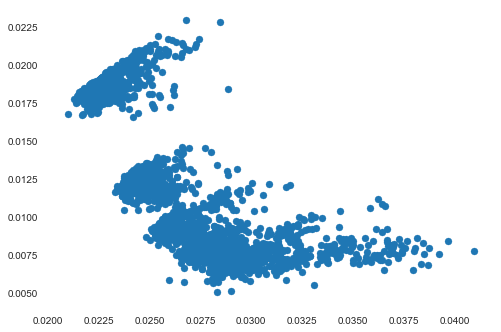

In [44]:
#Este Gráfico muestra |Error Validacion| vs |Diferencia de error entre entrenamiento y Validaciones|
#Lo anterior para contrastar cuan buen predictor es vs cuan bien generaliza. 
plt.scatter(df_randomForest["error"], df_randomForest["dif_error"])
plt.show()

In [ ]:
df_randomForest[(df_randomForest['error'] < 0.024) & (df_randomForest['dif_error'] < 0.0115 )]

In [51]:
for ele in Output:
    if ele[0] == 'RandomForest_40_90_5_80':
        mfinal = ele[4]

In [52]:
#Modelo Final dado lo anterior
mfinal

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=90, max_features=80, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [13]:
 model = RFR(n_estimators=40 , max_depth = 90 , min_samples_leaf = 5, max_features= 80)

In [19]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=90, max_features=80, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [20]:
MSLE(y_test, model.predict(X_test))

0.024185101702528144

## XGBOOST 

In [35]:
X_train, X_test, y_train, y_test, data_train = Preprocessing(df,1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
xgb_matrix = []

In [37]:
for gamma in list(arange(0,0.21,0.01)):
    for lr in list(arange(0.05,0.65,0.05)):
        for md in list(range(1,10,1)):
            for est in list(range(100,1600,100)):
                best_params = {'gamma': gamma, 'learning_rate': lr, 'max_depth': md, 'n_estimators': est}
                xgbo = xgb.XGBRegressor(**best_params)
                scores = cross_val_score(xgbo, X_train, y_train, cv=10)
                xgb_matrix.append([scores.mean(),gamma,lr,md,est])
                print(scores.mean())

0.7747673341571503
0.8003156622846561
0.812557723749198
0.8154767121048716
0.8173055773635192
0.8184099397395442
0.8198095931168352
0.8206933857967111
0.8211103880250021
0.8214345094188351
0.8215942993755437
0.8215138266080613
0.8211539175123447
0.8210518796145863
0.82075665859932
0.8251011184044754
0.8424771323686369
0.8473999263024258
0.8492882372989081


KeyboardInterrupt: 

In [144]:
xgb_matrix

[[0.7747673341571503, 0.0, 0.05, 1, 100],
 [0.8003156622846561, 0.0, 0.05, 1, 200],
 [0.812557723749198, 0.0, 0.05, 1, 300],
 [0.8154767121048716, 0.0, 0.05, 1, 400],
 [0.8173055773635192, 0.0, 0.05, 1, 500],
 [0.8184099397395442, 0.0, 0.05, 1, 600],
 [0.8198095931168352, 0.0, 0.05, 1, 700],
 [0.8206933857967111, 0.0, 0.05, 1, 800],
 [0.8211103880250021, 0.0, 0.05, 1, 900],
 [0.8214345094188351, 0.0, 0.05, 1, 1000],
 [0.8215942993755437, 0.0, 0.05, 1, 1100],
 [0.8215138266080613, 0.0, 0.05, 1, 1200],
 [0.8211539175123447, 0.0, 0.05, 1, 1300],
 [0.8210518796145863, 0.0, 0.05, 1, 1400],
 [0.82075665859932, 0.0, 0.05, 1, 1500],
 [0.8251011184044754, 0.0, 0.05, 2, 100],
 [0.8424771323686369, 0.0, 0.05, 2, 200],
 [0.8473999263024258, 0.0, 0.05, 2, 300],
 [0.8492882372989081, 0.0, 0.05, 2, 400],
 [0.8498043082260235, 0.0, 0.05, 2, 500],
 [0.8504581363189411, 0.0, 0.05, 2, 600],
 [0.8508500587808806, 0.0, 0.05, 2, 700],
 [0.8508168668976488, 0.0, 0.05, 2, 800],
 [0.8510921199970511, 0.0, 0.05

In [145]:
xgb_models = pd.DataFrame(xgb_matrix, columns=['cross_val_score','gamma','lr','md','est'])

In [147]:
xgb_models['cross_val_score'].max()

0.8556950183946013

In [148]:
xgb_models[xgb_models['cross_val_score'] == 0.8556950183946013]

,cross_val_score,gamma,lr,md,est
301,0.855695,0.00,0.15,3,200
1921,0.855695,0.01,0.15,3,200
3541,0.855695,0.02,0.15,3,200


In [38]:
#Final
best_params = {'gamma': 0.02, 'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 200}
xgbo = xgb.XGBRegressor(**best_params)
scores = cross_val_score(xgbo, X_train, y_train, cv=10)

In [39]:
xgbo.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.02, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [40]:
MSLE(y_test, xgbo.predict(X_test))

0.0185288968075887

In [151]:
Id, X_val, data_test = Preprocessing(df_test,0)

Upload = xgbo.predict(X_val)

Resultado = pd.DataFrame(list(zip(Id,Upload)), columns = ['Id','SalePrice'])

Resultado.to_csv('predicciones.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Guardando el modelo para la implementacion

In [98]:
import pickle

In [101]:
pickle.dump(xgbo, open("ModeloFinal/xgboost_precio_casa.model", "wb"))